In [1]:
import os

import pandas as pd
from matplotlib import pyplot as plt

from tsa.preprocessing import get_sample_info, tpm_normalization, merge_replicates
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.clustering import cluster_genes
from tsa.alignment import time_series_alignment
from tsa.utils import inference_timeseries, all_numeric, write_alignment

plt.rcParams['figure.figsize'] = [8, 6]

# Input files

In [2]:
tpm_file = "data/GRCz11-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

template_samples_file = "data/white_mpf_samples.tsv"
query_samples_file = "data/levin_mpf_samples.tsv"
# query_samples_file = "data/white_mpf_samples.tsv"  # control
# query_samples_file = "data/marletaz_mpf_samples.tsv"

# currently ran for 
# 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# with 171 points (10 per original timepoint)
new_gpr = False
gpr_inference_file = "data/white_mpf_gpr.tsv"
gpr_scores_file = "data/white_mpf_score.tsv"

showcase_gene = "ENSDARG00000000212"

# Infer expression over time for template genes

In [3]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

template_tpms = tpm_normalization(tpms, template_sample_order, min_value=5, min_median_value=0, verbose=True)

# sanity checks
print("\nchronological sample order:", template_sample_order[0:min(7, len(template_sample_order))], "\n")

print("samples per timepoint:")
keys = list(template_time2samples)
for n in range(min(3, len(keys))):
    print(keys[n], ":", template_time2samples[keys[n]])

print("\nnormalized TPMs:")
template_tpms.head(3)

11063 genes with max below 5 TPM (34%)
2243 genes with median below or equal to 0 TPM (10%)
18906 genes, 90 samples left after filtering

chronological sample order: ['1-cell-1', '1-cell-2', '1-cell-3', '1-cell-4', '1-cell-5', '2-cell-1', '2-cell-2'] 

samples per timepoint:
0.0 : ['1-cell-1', '1-cell-2', '1-cell-3', '1-cell-4', '1-cell-5']
45.0 : ['2-cell-1', '2-cell-2', '2-cell-3', '2-cell-4', '2-cell-5']
135.0 : ['128-cell-1', '128-cell-2', '128-cell-3', '128-cell-4', '128-cell-5']

normalized TPMs:


,1-cell-1,1-cell-2,1-cell-3,1-cell-4,1-cell-5,2-cell-1,2-cell-2,2-cell-3,2-cell-4,2-cell-5,...,Day-4-1,Day-4-2,Day-4-3,Day-4-4,Day-4-5,Day-5-1,Day-5-2,Day-5-3,Day-5-4,Day-5-5
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.500623,3.193223,2.993834,3.134451,2.930888,3.063963,3.358324,3.177872,3.182704,3.292535,...,1.268145,0.875185,1.372952,0.953276,1.219284,1.252780,1.293310,1.701401,1.087258,0.985310
ENSDARG00000000002,1.798363,1.850706,1.549031,1.842664,1.618451,2.919417,2.731890,2.547173,2.881035,2.495728,...,2.909071,3.259391,3.423040,3.203155,2.933308,3.054464,3.049627,3.124625,2.925538,3.317229
ENSDARG00000000018,3.825139,3.883515,3.443959,3.688393,3.947403,4.004615,4.161532,4.129312,4.164329,3.913867,...,4.537668,4.042059,4.059302,4.259864,4.103876,4.459250,4.421675,4.362885,4.252356,4.371778


In [4]:
help(gpr)

Help on function gpr in module tsa.gpr:

gpr(time2samples: dict, template_tpms: pandas.core.frame.DataFrame, extended_timepoints: list, plot=False, verbose=True, run_n: int = None)
    Infers Gaussian Process Regressions for each gene in the template_tpms dataframe (combining replicates).
    
    Returns 2 dataframe with gene names as index.
    The first dataframe contains inferred expression levels with the inferred time as column names.
    The second dataframe contains the R-squared and the sum of absolute differences for each GPR.
    
    Genes for which no model could be made contain zeroes and NaNs in the 2 dataframes, respectively.



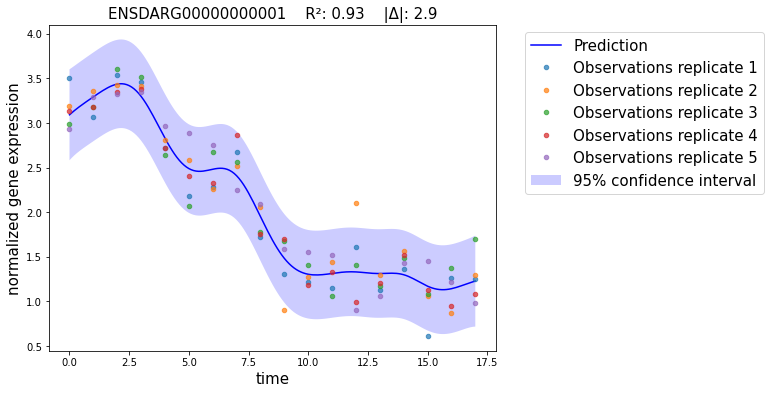

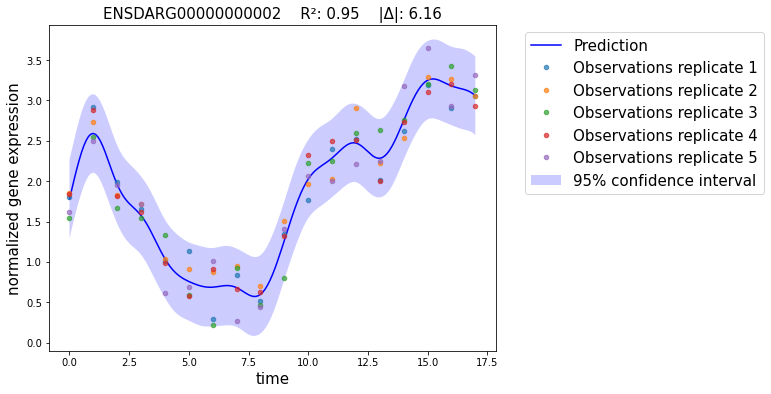

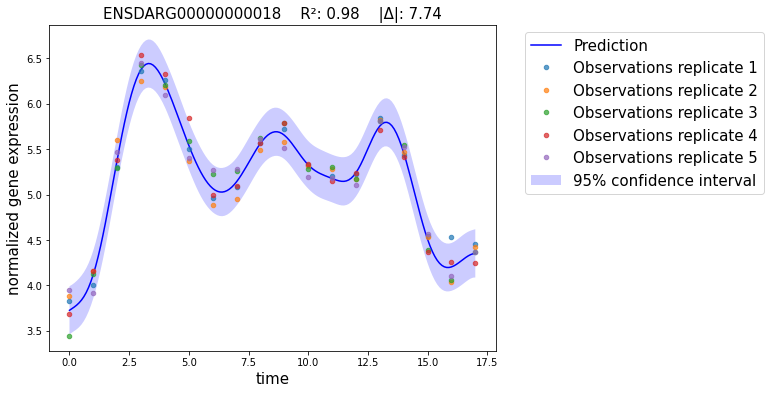

In [5]:
# # linear space
# extended_timepoints = list(np.round(np.linspace(min(time2samples), max(time2samples), 10), 2))

# infer n timepoints for each original timepoint 
timepoints_per_sample = 10
extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)

# run 3x with pictures
tmp, _ = gpr(template_time2samples, template_tpms, extended_timepoints, plot=True, verbose=False, run_n=3)

if new_gpr:
    # run with all genes
    template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(gpr_inference_file, sep="\t")
    gpr_scores.to_csv(gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
    gpr_scores = pd.read_csv(gpr_scores_file, sep="\t", index_col=0)


In [6]:
# when loading a gpr inference table, make sure the rows and columns match the settings
if new_gpr is False:
    gene = tmp.index[0]
    if tmp.index[0] != template_tpms_inf.index[0]:
        raise ValueError("`template_tpms` gene order has changed since creating the template_tpms_inf table")
    if tmp.columns.equals(template_tpms_inf.columns):
        raise ValueError("`extended_timepoints` has changed since creating the template_tpms_inf table")
    print("all good!")

all good!


### Filter template genes by GPR model accuracy (R-squared), expression variability, or both.

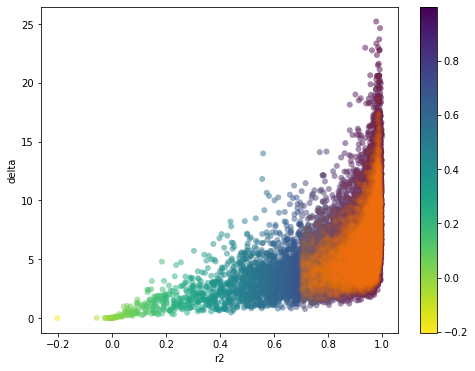

In [7]:
# remove genes that weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

gpr_scores.dropna(inplace=True)
gpr_normscores = score_normalization(gpr_scores, weight_expr, weight_r2)
top_template_genes = gpr_normscores[gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(gpr_normscores, highlight_top_n=len(top_template_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

# Gene selection

In [8]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms = tpm_normalization(tpms, sample_order, min_value=5, min_median_value=0, qnorm_target_dist=target_distribution)

# merge replicates (if any)
# TODO: other methods, such as GPR?
query_tpms = merge_replicates(query_tpms, time2samples, how="mean")

if all_numeric(time2samples):
    # convert time to numeric
    samples2time = query_samples.to_dict()["time"]
    query_tpms = query_tpms.rename(columns=samples2time)

# sanity checks
print("\nchronological sample order:", sample_order[0:min(7, len(sample_order))], "\n")

print("samples per timepoint:")
keys = list(time2samples)
for n in range(min(3, len(keys))):
    print(keys[n], ":", time2samples[keys[n]])

print("\nnormalized TPMs:")
query_tpms.head(3)

14459 genes with max below 5 TPM (44%)
10529 genes with median below or equal to 0 TPM (59%)
7224 genes, 106 samples left after filtering

chronological sample order: ['GSM1483736', 'GSM1483737', 'GSM1483738', 'GSM1483739', 'GSM1483740', 'GSM1483741', 'GSM1483742'] 

samples per timepoint:
40.0 : ['GSM1483736']
80.0 : ['GSM1483737']
120.0 : ['GSM1483738']

normalized TPMs:


,40.0,80.0,120.0,160.0,200.0,240.0,280.0,320.0,360.0,400.0,...,3880.0,3920.0,3960.0,4000.0,4040.0,4080.0,4120.0,4160.0,4200.0,4240.0
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000018,2.360602,1.296691,2.089290,2.228202,2.356633,2.140795,1.983877,1.484926,2.158373,2.329774,...,1.843847,2.110805,1.754697,2.643962,2.005010,1.935465,1.940635,1.541656,2.346414,1.819928
ENSDARG00000000019,2.382544,1.296691,1.853138,1.962398,2.395229,1.533743,2.558365,2.528215,1.384981,2.192685,...,2.049197,1.360626,0.799732,1.579541,1.617793,1.380723,0.799732,1.680871,2.110106,1.819928
ENSDARG00000000068,2.388446,1.296691,2.523750,0.889828,2.419689,2.408062,2.151466,1.484926,1.384981,1.285331,...,1.284130,0.799732,0.799732,1.579541,0.799732,1.863499,0.799732,1.968701,1.127709,1.819928


# Gene clustering (optional)

In [9]:
# set template_gene_clusters = None if clustering is not desired

help(cluster_genes)

Help on function cluster_genes in module tsa.clustering:

cluster_genes(df, genes=None, n_clusters=None, plot=True)
    Clusters a gene expression dataframe with gene names as index by K-means clustering.
    Filters the dataframe for {genes} if provided.
    If no {n_clusters} is specified, genes/300 is used (minimum 10).
    Returns a dataframe with gene names as index and cluster id in column "cluster"



6886 overlapping genes


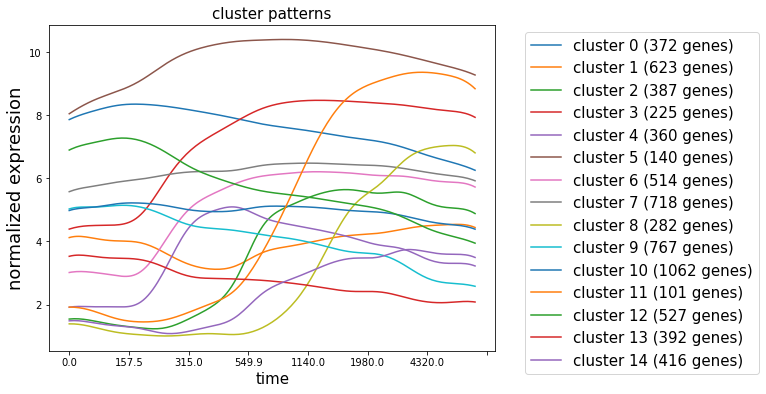

In [10]:
# overlap of query genes & top template genes
query_genes = query_tpms.index
starting_genes = set(top_template_genes).intersection(query_genes)

print(len(starting_genes), "overlapping genes")

template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes, 15)

# TSA

In [11]:
help(time_series_alignment)

Help on function time_series_alignment in module tsa.alignment:

time_series_alignment(template, query, gene_cluster_df=None, tries=10, frac=None, n_clust=None, n_total=None, cycles=1, shrink_rate=0.9, verbose=True, **kwargs)
    Apply a local time series alignment of {query} to {template}.
    Returns the path (and standard deviation if {return_std} is True) for each cycle.
    The path contains the indices of {template} columns best matching each {query} column.
    
    Uses a random fraction of genes (per cluster of genes if {gene_cluster_df} is provided).
    This is repeated several {tries}, and averaged to obtain an alignment path.
    
    If {cycles} > 1, the alignments will then be used to bootstrap a subsequent alignments:
    First by measuring the ({scale}d) Goodness of Fit for each gene,
    then selecting a top fraction of genes, based on the cumulative {shrink_rate}.
    This fraction is used for the next cycle's average alignment.
    
    Parameters
    ----------
   

In [12]:
# paths = [time_series_alignment(template_tpms_inf, query_tpms, template_gene_clusters, cycles=1, n_clust=50, tries=100, ncpu=40, showcase_gene=showcase_gene)]
# paths = time_series_alignment(template_tpms_inf, query_tpms, template_gene_clusters, cycles=3, n_clust=50, tries=100, ncpu=40, showcase_gene=showcase_gene)

In [13]:
# from tsa.alignment import plot_gene

# showcase_gene = "ENSDARG00000000212"
# # showcase_gene = 'ENSDARG00000101735'
# for path in paths:
#     plot_gene(query_tpms, template_tpms_inf, path, gene=showcase_gene, scale=False)  # scale=True, cycle=True)

Cycle 1, using all 6886 genes.

	TSA of 100 alignments, 600 genes.


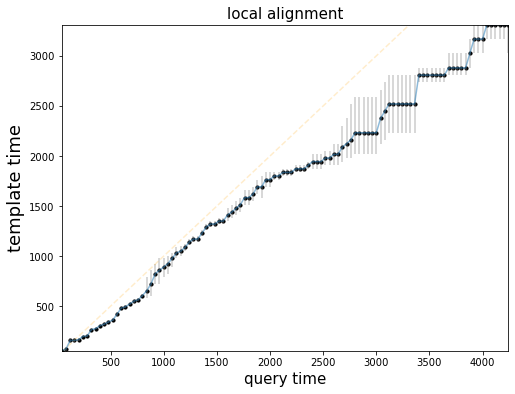

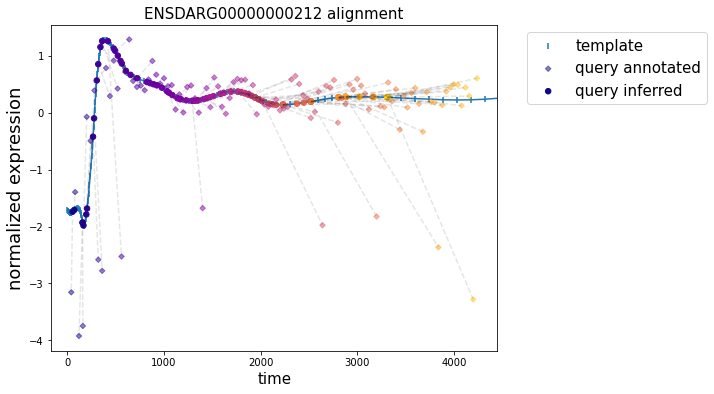

Cycle 2, using the best 6198 genes.

	TSA of 100 alignments, 600 genes.


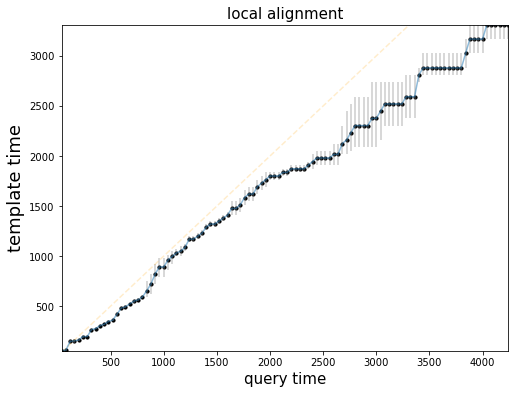

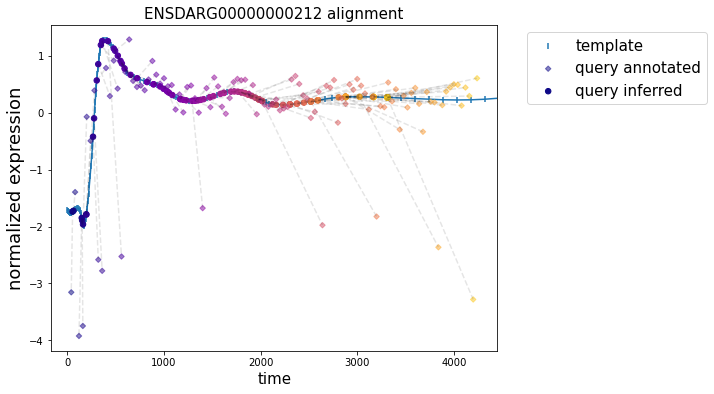

In [14]:
test = cluster_genes(template_tpms_inf, starting_genes, 1, plot=False)
paths = time_series_alignment(template_tpms_inf, query_tpms, test, cycles=2, n_total=600, tries=100, ncpu=40, showcase_gene=showcase_gene, metric="correlation")

In [15]:
# # showcase_gene = "ENSDARG00000000212"
# showcase_gene = 'ENSDARG00000101735'
# for path in paths2:
#     plot_gene(query_tpms, template_tpms_inf, path, gene=showcase_gene, scale=True)  # scale=True, cycle=True)

## Save TSA results

In [16]:
path = paths[0]
alignment_dir = "alignments"
template_name = os.path.basename(template_samples_file).replace("_samples.tsv", "")
query_name = os.path.basename(query_samples_file).replace("_samples.tsv", "")

# mapped = write_alignment(template_name, query_name, time2samples, extended_timepoints, path, alignment_dir, force=False)

# mapped.head(3)

##### Align all queries (and the template), then continue to combine_alignments.ipynb